# Using Cardiac Factors To Predict Whether Individuals Will Experience Heart Failure
#### Harsh A, Kyle M, Daniel L, Catarina A 

### Introduction
Cardiovascular diseases and heart failure account for the greatest amount of deaths per year globally, accounting for approximately a third of the global annual deaths. The main causes leading to heart failure are often associated with increased blood pressure (hypertension) and closing of the arteries (build-up of cholesterol and fats), both of which are indicated by an individual's maximum heart rate and are often associated with aging.

The goal of this project will be to use these factors from a heart failure data set, which includes the data from various heart disease patients from 4 demographics, to create a somewhat accurate model in order to diagnose whether an individual has heart disease and will experience heart failure.

**Question:** Can we predict whether a patient will experience heart failure (caused by heart disease) based on their age, resting blood pressure, cholesterol, and maximum heart rate?

### Preliminary Exploratory Data Analysis

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [14]:
set.seed(50)
#loading raw dataset with new clean column names
heart_raw <- read_csv("https://raw.githubusercontent.com/hamin2006/Group_Project_7/main/data/heart1.csv",  
                       skip = 1, 
                       col_names = c("age","sex","chest_pain","resting_bp","cholesterol","fasting_bs","rest_ecg",
                                    "max_heart_rate","excercise_angina","old_peak","st_slope","heart_failure")) 

#cleaning data and selecting predictor variables
heart_data <- heart_raw |>
    mutate(heart_failure = as_factor(heart_failure),
           heart_failure = fct_recode(heart_failure, "Healthy" = "0", "Unhealthy" = "1")) |> 
    select(age, resting_bp, cholesterol, max_heart_rate, heart_failure) 

#splitting clean data into training and testing sets
heart_split <- initial_split(heart_data, prop = 0.75, strata = heart_failure)

heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

heart_training

Rows: 746 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): sex, chest_pain, rest_ecg, excercise_angina, st_slope
dbl (7): age, resting_bp, cholesterol, fasting_bs, max_heart_rate, old_peak,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,resting_bp,cholesterol,max_heart_rate,heart_failure
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,Healthy
37,130,283,98,Healthy
54,150,195,122,Healthy
⋮,⋮,⋮,⋮,⋮
68,144,193,141,Unhealthy
57,130,131,115,Unhealthy
57,130,236,174,Unhealthy


In [15]:
#summarization of training data
heart_training_summary <- heart_training |>
    group_by(heart_failure) |>
    summarize (patients = n(),
              mean_age = mean(age),
              mean_resting_bp = mean(resting_bp),
              mean_cholesterol = mean(cholesterol),
              mean_max_heart_rate = mean(max_heart_rate),
              missing_data = sum(is.na(heart_failure)) + sum(is.na(age)) + sum(is.na(resting_bp)) + sum(is.na(cholesterol)) + sum(is.na(max_heart_rate)))

heart_training_summary

heart_failure,patients,mean_age,mean_resting_bp,mean_cholesterol,mean_max_heart_rate,missing_data
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Healthy,292,50.42808,129.4589,238.6199,150.2158,0
Unhealthy,267,56.57678,137.0861,248.3858,130.9288,0


Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


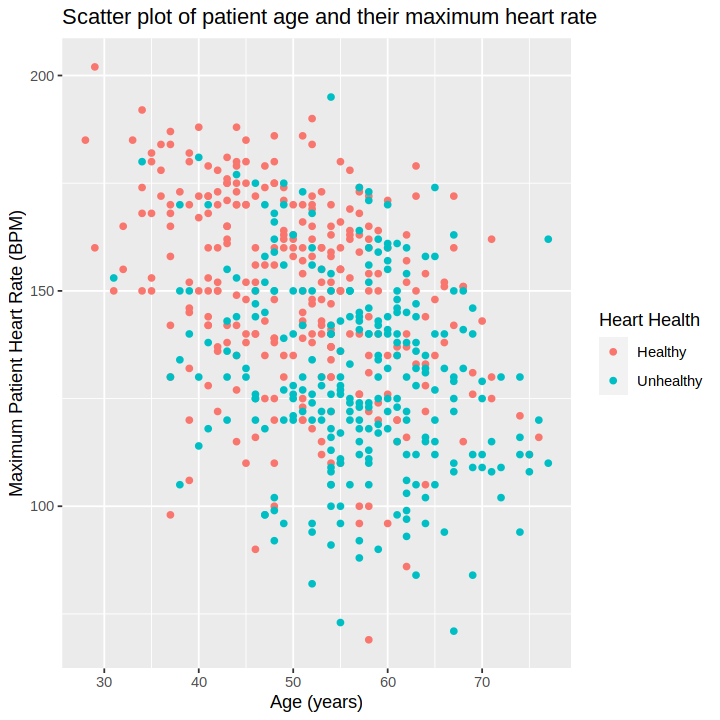

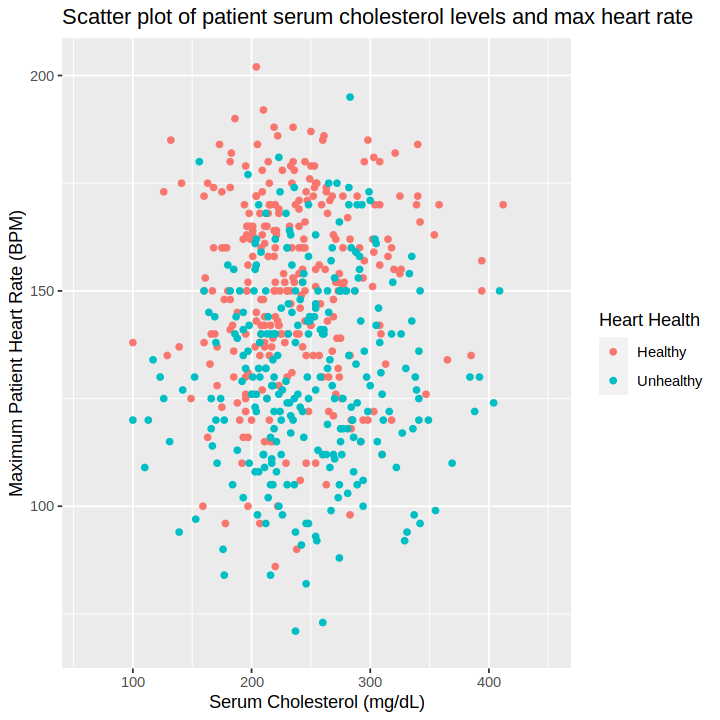

In [ ]:
options(repr.plot.height = 6, repr.plot.width = 6)
plot1 <- ggplot(heart_training, aes(x = age, y = resting_bp, colour = heart_failure)) +
                geom_point() +
                labs(x = "Age (years)", y = "Resting Systolic Blood Pressure (mm Hg)", 
                     colour = "Heart Health",
                     title = "Scatter plot of patient age and their resting systolic blood pressure")

plot2 <- ggplot(heart_training, aes(x = age, y = max_heart_rate, colour = heart_failure)) +
                geom_point() +
                labs(x = "Age (years)", y = "Maximum Patient Heart Rate (BPM)", 
                     colour = "Heart Health",
                     title = "Scatter plot of patient age and their maximum heart rate")

plot3 <- ggplot(heart_training, aes(x = cholesterol, y = max_heart_rate, colour = heart_failure)) +
                geom_point() +
                labs(x = "Serum Cholesterol (mg/dL)", y = "Maximum Patient Heart Rate (BPM)",
                     colour = "Heart Health",
                     title = "Scatter plot of patient serum cholesterol levels and max heart rate") +
                xlim(c(60,450))

plot2
plot3
plot1

### Methods
**Choosing Variables:** To choose our variables for prediction we turned to the Centers for Disease Control and Prevention which stated that high blood pressure and cholesterol are the main factors which cause heart disease and failure. Furthermore, we determined that low maximum heart rate is an indicator of high blood pressure (stated by the National Library of Medicine) and is often related to aging, giving us our 4 predictor variables whose same trends can be seen in the above scatterplots.

**Data Analysis:** We decided to use the K-nearest classification method. First, we will split our data set into training and testing data using a 0.75 split on the heart_failure column as a strata. Then we will set up a tuning model with the training data, performing 5-fold cross-validation and resampling our data, to decide which K value provides us with the most accuracy, we will use a scatter + line plot to express the accuracy relationship with the number of neighbours. Once the most accurate K value is found we will set up a final classification model using this K value which will create predictions on the testing partition of the data set. We will then collect metrics and interpret the model's accuracy in order to answer our predictive question.

**Visualizations:** In order to visualize the results we will make 2 bar plots to compare the spread of the results across the diagnosis. One plot will contain the theoretical/correct results and the other plot will contain the predictive results to express the difference between the truth and estimate data classifications.

### Expected Outcomes And Significance
**Expectations:**
We expect to find that older individuals with increased resting blood pressure, increased cholesterol levels, and decreased maximum heart rate will experience heart failure in their lifetimes.

**Impact:**
An accurate prediction model could greatly help doctors diagnose heart diseases and begin early treatment to maximize an individual's health. At blood checkups, a nurse would only have to input an individual's testing results in order to successfully diagnose a patient. This model could also help individuals clarify whether they are at risk of heart disease and would allow them to build precautions to mitigate the effects.

**Future Questions:**
- Can we create a regression model to find the healthy value of blood pressure, cholesterol, and max heart rate compared to an individuals age?
- How versatile is this model? Will it be just as accurate on individual's from a different demographic?

### Citations

Fedesoriano. (2021, September 10). *Heart failure prediction dataset*. Kaggle. 
>https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

CDC.gov. (2022, September 8). *Heart disease and stroke*. Centers for Disease Control and Prevention. 
>https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm#:~:text=Leading%20risk%20factors%20for%20heart,unhealthy%20diet%2C%20and%20physical%20inactivity 
    
Reule, S., &amp; Drawz, P. E. (2012, December). *Heart rate and blood pressure: Any possible implications for management of hypertension?*. Current hypertension reports.
>https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3491126/#:~:text=The%20relationship%20between%20heart%20rate%20and%20blood%20pressure%20is%20location,rate%20and%20central%20blood%20pressures 